In [1]:
import os
import polars as pl

import torch
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from torchinfo import summary
import gc
from torchmetrics.classification import BinaryF1Score
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pl.read_parquet(
    r"/home/pampa89d/Repo/mentor/rubert_bynary_clas/data/processed_combined.parquet"
)
df.head()

message,label
str,i64
"""Привет чтото подобное делал ес…",0
"""Я уже сам отключил, через стар…",0
"""Страны ес согласовали санкции …",0
"""Кипячу, не кипячусь я добрая п…",0
"""Avalonia for visual studio 201…",0


In [3]:
small_df = df.sample(n=20_000, shuffle=True)

In [4]:
small_df.group_by("label").len()

label,len
i64,u32
0,18378
1,1622


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2", num_labels=2
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

Заморозка слоев

In [6]:
# Принудительная очистка
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Пример для передачи двух входов: input_ids
# если нужен attention_mask добавить как список
# input_size = (batch_size, sequence_length)
summary(model, input_size=(16, 512), dtypes=[torch.long])

In [7]:
class CustomImageDataset(Dataset):
    def __init__(
        self, texts: List, labels: List, tokenizer: AutoTokenizer, max_len: int = 512
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Получаем текст по индексу
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Токенизация для BERT
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(dim=0),
            "attention_mask": encoding["attention_mask"].squeeze(dim=0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [8]:
train_df = small_df[:15_000]
val_df = small_df[15_000:]

training_dataset = CustomImageDataset(train_df["message"], train_df["label"], tokenizer)
val_dataset = CustomImageDataset(val_df["message"], val_df["label"], tokenizer)

In [9]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
next(iter(train_dataloader))

{'input_ids': tensor([[    2,  9672, 34650,  ...,     0,     0,     0],
         [    2,   282,  2079,  ...,     0,     0,     0],
         [    2, 30479, 23343,  ...,     0,     0,     0],
         ...,
         [    2, 29735,  1109,  ...,     0,     0,     0],
         [    2,     1,  2399,  ...,     0,     0,     0],
         [    2, 10721,   769,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0])}

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
f1_metric = BinaryF1Score().to(device)


def train(model, train_loader, val_loader, optimizer, metric, epochs):
    """
    Функция для обучения и валидации нейросети
    """
    train_losses = []
    valid_losses = []

    f1_scores_train = []
    f1_scores_valid = []

    for epoch in range(epochs):

        model.train()
        train_loss = 0.0
        train_f1 = 0.0

        for batch in tqdm(train_loader):

            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            predict = torch.argmax(outputs.logits, dim=1)

            f1_score = metric(predict, labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_f1 += f1_score.item()
            train_loss += loss.item()

        avg_train_f1 = round((train_f1 / len(train_loader)), 4)
        avg_train_loss = round((train_loss / len(train_loader)), 4)

        f1_scores_train.append(avg_train_f1)
        train_losses.append(avg_train_loss)

        print(
            f"Epoch {epoch+1}. Average train loss {avg_train_loss}. Average train F1_score {avg_train_f1}"
        )

        model.eval()
        val_loss = 0.0
        valid_f1 = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader):

                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids, attention_mask=attention_mask, labels=labels
                )
                predict = torch.argmax(outputs.logits, dim=1)

                f1_score = metric(predict, labels)

                loss = outputs.loss

                valid_f1 += f1_score.item()
                val_loss += loss.item()

        avg_val_f1 = round((valid_f1 / len(val_loader)), 4)
        avg_val_loss = round((val_loss / len(val_loader)), 4)

        f1_scores_valid.append(avg_val_f1)
        valid_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch+1}. Average valid loss {avg_val_loss}. . Average train F1_score {avg_val_f1}."
        )

        # backup
        model.save_pretrained("./models")
        tokenizer.save_pretrained("./models")

    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "f1_scores_train": f1_scores_train,
        "f1_scores_valid": f1_scores_valid,
    }

In [21]:
results = train(model, train_dataloader, val_dataloader, optimizer, f1_metric, epochs=2)

100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


Epoch 1. Average train loss 0.0026. Average train F1_score 0.944


100%|██████████| 157/157 [00:26<00:00,  5.97it/s]


Epoch 1. Average valid loss 0.0662. . Average train F1_score 0.8174.


100%|██████████| 469/469 [03:17<00:00,  2.37it/s]


Epoch 2. Average train loss 0.0029. Average train F1_score 0.941


100%|██████████| 157/157 [00:26<00:00,  5.91it/s]


Epoch 2. Average valid loss 0.0498. . Average train F1_score 0.8532.


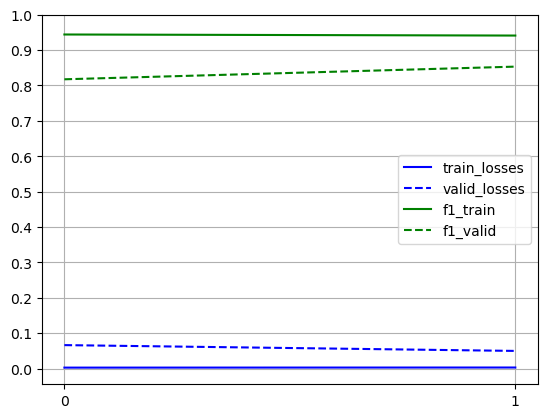

In [ ]:
plt.plot(results["train_losses"], color="blue", label="train_losses")
plt.plot(results["valid_losses"], color="blue", linestyle="--", label="valid_losses")
plt.plot(results["f1_scores_train"], color="green", label="f1_train")
plt.plot(results["f1_scores_valid"], color="green", linestyle="--", label="f1_valid")
plt.legend()
plt.xticks([i for i in range(len(results["train_losses"]))])
plt.yticks([(i + 1) * 0.1 for i in range(-1, 10)])
plt.grid()
plt.show()

Загрузка сохранненой модели HF

In [2]:
model = BertForSequenceClassification.from_pretrained("./models")
tokenizer = AutoTokenizer.from_pretrained("./models")

In [31]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [33]:
inputs = tokenizer(
    df.filter(pl.col("label") == 1)[-5:]["message"].to_list(),
    add_special_tokens=True,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

In [37]:
outputs = model(**inputs.to(device))

In [43]:
torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist()

[1, 1, 1, 1, 1]

In [45]:
df.filter(pl.col("label") == 1)[-5:]["message"].to_list()

['ВАТИТ ЖИТЬ 0Т ЗAР ЛAТЫ ДО ЗAPПЛАТЫ 2 4 чαсσв и твой дохσд от 8000 в день Pа6отαешь ᴋогда удσбнσ. Никαᴋих пρσдаж и встрeч. одσйдет дαжe ᴄтудентαᴍ',
 'Ecть ваpиант пoлyчить 3300 pyблeй за 2 чаca oтпишитe в лc',
 'Нужны cpочho люди нa шaбашку нa 45 чaсов в дeнь плaчy 15тыcяч сразy поcлe смeны',
 'Вaтит жить 0т зaрплаты до заpплаты 2 4 чαсσв и твσй дохσд σт 8000 в дeнь рα6отαeшь кσгдα удσ6но никаᴋи πрσдаж и вᴄтρеч одойдeт дαжe стγдeнтαᴍ',
 'Нужны молодые смекалистые ребята и девушки места ограничены']